# Summary

Adding the new feature is slightly better than other solutions, that is a heuristic model as well as the model currently in production (whether retrained or not). 

Other values of max_depth for the new model were checked. The old value of 1 is still the best one.

The new model comes with a disadvantage of not being able to predict a score on articles that miss their content in the API and there were a few of such records already in the dataset. However, it's probably worth it to put the new model into production and reevaluate the new feature's impact again when more data is gathered. 

# Setup

In [1]:
%config Completer.use_jedi = False

In [2]:
import pickle
import re

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor

from dataprep import db_to_df

# Data preparation

In [3]:
articles = db_to_df()
articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 1 to 57
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   author                          41 non-null     object 
 1   title                           57 non-null     object 
 2   url                             57 non-null     object 
 3   published_at                    57 non-null     object 
 4   content                         54 non-null     object 
 5   source_name                     57 non-null     object 
 6   predicted_score_when_presented  57 non-null     float64
 7   assigned_score                  57 non-null     int64  
 8   is_test_record                  57 non-null     int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 4.5+ KB


In [4]:
articles['published_at'] = pd.to_datetime(articles['published_at'])

In [5]:
articles.head()

,author,title,url,published_at,content,source_name,predicted_score_when_presented,assigned_score,is_test_record
id,,,,,,,,,
1,Tyler Sullivan,"2022 NFL Free Agency tracker: Live updates, la...",https://www.cbssports.com/nfl/news/2022-nfl-fr...,2022-03-15 14:35:03+00:00,The dominos are continuing to fall across the ...,CBS Sports,50.0,-999,0
2,"By <a href=""/profiles/jessie-yeung"">Jessie Yeu...",Russia invades Ukraine: Live updates - CNN,https://www.cnn.com/europe/live-news/ukraine-r...,2022-03-05 06:27:00+00:00,"Russia is poised to deploy up to 1,000 more me...",CNN,50.0,-999,1
3,"By <a href=""/profiles/jessie-yeung"">Jessie Yeu...",Russia invades Ukraine: Live updates - CNN,https://www.cnn.com/europe/live-news/ukraine-r...,2022-03-05 06:27:00+00:00,"Russia is poised to deploy up to 1,000 more me...",CNN,50.0,95,0
4,None,Apple presses U.S. lawmakers on dangers of 'si...,https://www.reuters.com/technology/apple-press...,2022-03-04 22:13:00+00:00,"WASHINGTON, March 4 (Reuters) - Smartphone mak...",Reuters,50.0,50,1
5,Brent Sobleski,Top 5 Potential Landing Spots for Dallas Cowbo...,https://bleacherreport.com/articles/2954024-to...,2022-03-04 22:34:10+00:00,Ron Schwane/Associated Press\r\nMuch like Coop...,Bleacher Report,50.0,0,0


In [6]:
# drop dummy records

n_rows_bef = len(articles)
articles = articles[articles['assigned_score']!=-999]
n_rows_after = len(articles)
print(f'{n_rows_bef - n_rows_after} rows dropped.')

2 rows dropped.


In [7]:
# drop duplicates

n_rows_bef = len(articles)
articles = articles.drop_duplicates(subset=['title', 'published_at'])
n_rows_after = len(articles)
print(f'{n_rows_bef - n_rows_after} rows dropped.')

0 rows dropped.


In [8]:
training = articles[articles['is_test_record']==0].copy()
test = articles[articles['is_test_record']==1].copy()

print(f'Number of training records: {len(training)}')
print(f'Number of test records: {len(test)}')

Number of training records: 26
Number of test records: 29


# Add article length

Adding this features excludes all records for which no content is provided.

In [9]:
n_rows_bef = len(training)
training.dropna(subset='content', inplace=True)
n_rows_after = len(training)
print(f'{n_rows_bef - n_rows_after} rows dropped from the training set.')

n_rows_bef = len(test)
test.dropna(subset='content', inplace=True)
n_rows_after = len(test)
print(f'{n_rows_bef - n_rows_after} rows dropped from the test set.')

0 rows dropped from the training set.
3 rows dropped from the test set.


In [10]:
text = training.loc[7, 'content']
text

'The Islamic State (ISIS) has claimed responsibility for Fridays attack on a Shia mosque in Pakistans northwestern city of Peshawar that killed at least 61 people and injured another 196.\r\nA post from… [+1098 chars]'

In [11]:
content_end = text[-15:]
content_end

'… [+1098 chars]'

In [12]:
re.search('\d+', content_end)[0]

'1098'

In [13]:
def derive_content_length(row):
    content = row['content']
    content_end = content[-15:]
    match = re.search('\d+', content_end)
    
    if match:
        content_length = match[0]
        return int(content_length)
    else:
        return np.nan

In [14]:
training['content_length_chars'] = training.apply(derive_content_length, axis=1)

n_rows_bef = len(training)
training.dropna(subset='content_length_chars', inplace=True)
n_rows_after = len(training)
print(f'{n_rows_bef - n_rows_after} rows dropped from the training set.')

0 rows dropped from the training set.


In [15]:
pd.set_option('max_colwidth', 300)
display(training[['content', 'content_length_chars']].head())
pd.set_option('max_colwidth', 50)

,content,content_length_chars
id,,
3,"Russia is poised to deploy up to 1,000 more mercenaries to Ukraine in the coming days and weeks, as a senior Western intelligence official warned Moscow could ""bombard cities into submission,"" an esc… [+2655 chars]",2655
5,"Ron Schwane/Associated Press\r\nMuch like Cooper and the Cowboys, Jarvis Landry and the Cleveland Browns appear to be parting ways imminently. \r\nLandry spoke out about his current situation on social m… [+1259 chars]",1259
7,The Islamic State (ISIS) has claimed responsibility for Fridays attack on a Shia mosque in Pakistans northwestern city of Peshawar that killed at least 61 people and injured another 196.\r\nA post from… [+1098 chars],1098
10,"The stance of those opposed to the development, Ms. Jagadeesh added, clashes sharply with the Mothers vision for a model city of the future that would be replicated around the world.\r\nWe are here for… [+931 chars]",931
12,"SpaceX's Elon Musk tweeted on Saturday that Starlink was told by some governments to block Russian news sources. \r\nMusk said on Twitter: ""Starlink has been told by some governments (not Ukraine) to b… [+1425 chars]",1425


# EDA

<AxesSubplot:xlabel='assigned_score', ylabel='Count'>

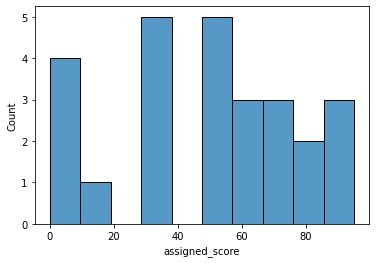

In [16]:
sns.histplot(training['assigned_score'], bins=10)
# assigned score is the target value assigned by the user

Some value ranges in the training set are missing which is to be expected by such a small dataset.

In [17]:
print(len(training))
print(training['author'].nunique())

26
21


Out of 26 records, 21 have a unique author. This means the feature is not likely to be helpful for most records.

In [18]:
print(len(training))
print(training['source_name'].nunique())

26
16


Out of 26 records, 16 have a unique source. This is better than authors, but still may bring not too many information. This should improve as more data is gathered as sources are much less numerous in the real world than authors. While gathering more data, it's likely that the sources will constantly reappear.

<AxesSubplot:xlabel='content_length_chars', ylabel='Count'>

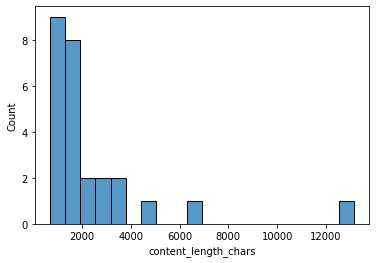

In [19]:
sns.histplot(training['content_length_chars'], bins=20)

Around three quarters of articles have their length under 2000 characters.

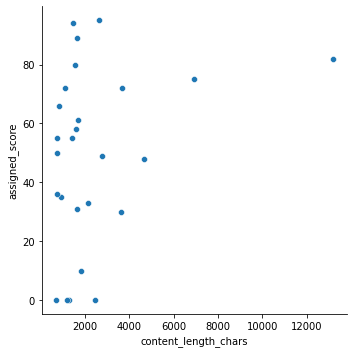

In [20]:
sns.relplot(x='content_length_chars', y='assigned_score', data=training)

In [21]:
corr = np.corrcoef(training['content_length_chars'], training['assigned_score'])[1][0]
print(round(corr, 2))

0.3


The correlation coefficient is small but meaningful. Looking at the plot though, it's possible that the coefficient is driven by the two outliers as other data points form a vertical line.

# Modeling

The dataset is very small, so all results are in reality rather unreliable.

In [22]:
y_train = training['assigned_score']
y_test = test['assigned_score']

In [23]:
seed = 23

## Baseline model

In [24]:
class BaselineModel:
    
    def train(self, y_train):
        self.mean_y = y_train.mean()
        
    def predict(self, x):
        n_preds = len(x)
        return np.full(n_preds, self.mean_y)

In [25]:
model = BaselineModel()
model.train(y_train)
y_pred = model.predict(test)

bl_mae = mean_absolute_error(y_pred, y_test)
print(f'MAE for the baseline model : {round(bl_mae, 2)}')

MAE for the baseline model : 29.25


## Current model

In [26]:
feature_cols = ['author', 'source_name']

In [27]:
x_test = test[feature_cols]

encoder = pickle.load(open('source_encoder.pkl', 'rb'))
x_test = encoder.transform(x_test)

In [28]:
model = pickle.load(open('ml_model.pkl', 'rb'))
y_pred = model.predict(x_test)

cur_mae = mean_absolute_error(y_pred, y_test)
print(f'MAE for the model currently in production: {round(cur_mae, 2)}')

MAE for the model currently in production: 30.31


## Current model - retrained

In [29]:
x_train = training[feature_cols]
x_test = test[feature_cols]

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999)
encoder.fit(x_train)

x_train = encoder.transform(x_train)
x_test = encoder.transform(x_test)

In [30]:
model = DecisionTreeRegressor(random_state=seed, max_depth=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

rt_mae = mean_absolute_error(y_pred, y_test)
print(f'MAE for the retrained model: {round(rt_mae, 2)}')

MAE for the retrained model: 29.97


In [31]:
y_pred = model.predict(x_train)
rt_mae_train = mean_absolute_error(y_pred, y_train)
print(f'Training set MAE for the retrained model: {round(rt_mae_train, 2)}')

Training set MAE for the retrained model: 23.1


## Adding the content length

In [32]:
test['content_length_chars'] = test.apply(derive_content_length, axis=1)
n_rows_bef = len(test)
test.dropna(subset='content_length_chars', inplace=True)
n_rows_after = len(test)
print(f'{n_rows_bef - n_rows_after} rows dropped from the test set.')

1 rows dropped from the test set.


In [33]:
cat_cols = ['author', 'source_name']
feature_cols = feature_cols + ['content_length_chars']
x_train = training[feature_cols].copy()
x_test = test[feature_cols].copy()
y_test = test['assigned_score']

In [34]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999)
encoder.fit(x_train[cat_cols])

x_train[cat_cols] = encoder.transform(x_train[cat_cols])
x_test[cat_cols] = encoder.transform(x_test[cat_cols])

In [35]:
model = DecisionTreeRegressor(random_state=seed, max_depth=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

rt_mae = mean_absolute_error(y_pred, y_test)
print(f'MAE for the model with the new feature: {round(rt_mae, 2)}')

MAE for the model with the new feature: 28.4


This score is slightly better than other solutions.

It's also worth checking whether adding this feature as well as more data would work better with a different value of the tree's max depth.

### Checking new max_depth value

In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
params = {
    'max_depth': (1, 2, 3, 4, 5, None)
}

model = DecisionTreeRegressor(random_state=seed)
grid = GridSearchCV(model, params, scoring='neg_mean_absolute_error')
grid.fit(x_train, y_train)
results = pd.DataFrame(grid.cv_results_)

In [38]:
grid.best_params_

{'max_depth': 1}

In [39]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001097,2.101809e-04,0.000788,2.405304e-04,1,{'max_depth': 1},-33.333333,-18.210,-28.083333,-28.100000,-17.650000,-25.075333,6.142632,1
1,0.001091,1.981976e-04,0.000595,1.984359e-04,2,{'max_depth': 2},-34.796970,-21.280,-37.500000,-26.618182,-19.466667,-27.932364,7.159770,2
2,0.000992,1.784161e-07,0.000496,1.784161e-07,3,{'max_depth': 3},-31.844444,-13.100,-37.366667,-28.866667,-29.466667,-28.128889,8.091271,3
3,0.000992,2.780415e-07,0.000595,1.981736e-04,4,{'max_depth': 4},-30.150000,-26.025,-40.300000,-30.600000,-30.450000,-31.505000,4.714881,4
4,0.000898,2.038133e-04,0.000496,3.170160e-06,5,{'max_depth': 5},-37.875000,-30.050,-41.600000,-36.700000,-34.800000,-36.205000,3.794680,5
5,0.000895,1.977714e-04,0.000594,1.949566e-04,None,{'max_depth': None},-39.166667,-31.600,-45.800000,-35.000000,-44.000000,-39.113333,5.328481,6


Max depth of 1 is still the best.